In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab

/content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab


# Heterogenous Ensemble

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions_2_ as fun
import deep_learning_helper as dp
import keras
import tensorflow as tf
import sklearn

%load_ext autoreload
%autoreload 2

from keras import models
from tensorflow.keras import layers

In [4]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

,epoch_utc,emission_factor,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,298.240217,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,266.522473,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,262.594215,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,260.190772,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,250.496683,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


In [5]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [6]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [7]:
# check features
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


## Feature Enginnering

## Feature Enginnering

### Create lagged features

In [8]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 26)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,...,y_lag_17,y_lag_18,y_lag_19,y_lag_20,y_lag_21,y_lag_22,y_lag_23,y_lag_24,y_lag_25,y_lag_26
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,298.240217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,266.522473,298.240217,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,262.594215,266.522473,298.240217,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.190772,262.594215,266.522473,298.240217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# add lag 24 and 26 to the features

features[['co2_24_lag','co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0,0.0,0.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0,0.0,0.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0,0.0,0.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0,0.0,0.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0,0.0,0.0


### Create temproal features

In [10]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [11]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag,hour_of_day,day_of_week,hour_of_year
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1354.0,224.0,0.0,0.0,800.0,0.0,0.0,23,0,8759
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,1158.0,0.0,0.0,1.0,801.0,0.0,0.0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,1176.0,0.0,0.0,0.0,800.0,0.0,0.0,1,1,1
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,1428.0,0.0,0.0,0.0,800.0,0.0,0.0,2,1,2
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,1492.0,0.0,0.0,0.0,800.0,0.0,0.0,3,1,3


In [12]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,co2_26_lag,hour_of_day,hour_of_year,day_of_week_fri,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,0.0,23,8759,0,1,0,0,0,0,0
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0.0,0,0,0,0,0,0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0.0,1,1,0,0,0,0,0,1,0
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0.0,2,2,0,0,0,0,0,1,0
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0.0,3,3,0,0,0,0,0,1,0


In [13]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998




```
# Als Code formatiert
```

## Test val split

In [14]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)+1]
co2_train_val = co2[0:int(n*val_ratio)+1]
co2_val = co2[int(n*train_ratio)+1:int(n*val_ratio)+1]
co2_test = co2[int(n*val_ratio)+1:n-23]
co22 = co2[:len(co2)-23]


# split the features into train and test set
features_train = features[0:int(n*train_ratio)+1]
features_train_val = features[0:int(n*val_ratio)+1]
features_val = features[int(n*train_ratio)+1:int(n*val_ratio)+1]
features_test = features[int(n*val_ratio)+1:n-23]
features2 = features[:len(features)-23]

date_val = date[int(n*train_ratio)+1:int(n*val_ratio)+1]
date_test = date[int(n*val_ratio)+1:n-23]


assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [15]:
co2.shape, features.shape

((30239,), (30239, 32))

In [16]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


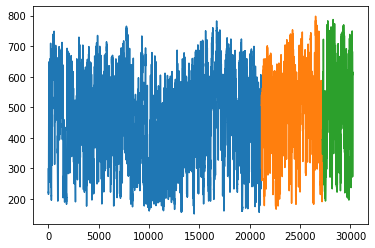

In [17]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

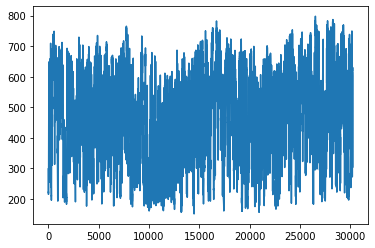

In [18]:
plt.plot(co2)

### Create walk forward split

In [19]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


In [20]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [21]:
for train_index, test_index in tscv_val.split(co2_train_val):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

TRAIN: [    0     1     2 ... 21165 21166 21167] TEST: [21168 21169 21170 21171 21172 21173 21174 21175 21176 21177 21178 21179
 21180 21181 21182 21183 21184 21185 21186 21187 21188 21189 21190 21191
 21192 21193 21194 21195 21196 21197 21198 21199 21200 21201 21202 21203
 21204 21205 21206 21207 21208 21209 21210 21211 21212 21213 21214 21215
 21216 21217 21218 21219 21220 21221 21222 21223 21224 21225 21226 21227
 21228 21229 21230 21231 21232 21233 21234 21235 21236 21237 21238 21239
 21240 21241 21242 21243 21244 21245 21246 21247 21248 21249 21250 21251
 21252 21253 21254 21255 21256 21257 21258 21259 21260 21261 21262 21263
 21264 21265 21266 21267 21268 21269 21270 21271 21272 21273 21274 21275
 21276 21277 21278 21279 21280 21281 21282 21283 21284 21285 21286 21287
 21288 21289 21290 21291 21292 21293 21294 21295 21296 21297 21298 21299
 21300 21301 21302 21303 21304 21305 21306 21307 21308 21309 21310 21311
 21312 21313 21314 21315 21316 21317 21318 21319 21320 21321 21322 21

In [22]:
co2_train_val.shape, co2_test.shape, co2.shape, co2_val.shape, co2_train.shape

((27216,), (3000,), (30239,), (6048,), (21168,))

In [23]:
len(co2_train_val) - len(co2_val) 

21168

In [24]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 125)

In [25]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

## het enesmble: define base models

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import het

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
learning_rate_mlp = 0.001
learning_rate_lstm = 0.3
loss = 'mse'
optimizer_mlp = tf.keras.optimizers.Adamax(learning_rate = learning_rate_mlp)
optimizer_lstm = 'Adam'
activation = 'relu'
dp_rate = 0.6
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)
#metrics=[tf.keras.metrics.RootMeanSquaredError()]

In [27]:
callback_test = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 0,
    patience = 25,
    mode = 'auto',
    restore_best_weights = True
)

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (2,0,1)
seasonal_config = (2,0,2,forecast_period)
sarmax = SARIMAX(endog = co2_train, exog= features_train,  order = config_sarma, seasonal_order  = seasonal_config)
sarmax_fit= sarmax.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (3,0,1)
seasonal_config = (1,0,1,24)
sarma = SARIMAX(co2_train, order = config_sarma, seasonal_order = seasonal_config)
sarma_fit = sarma.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [30]:
import joblib

In [ ]:
joblib.dump(sarmax_fit, 'sarmax_val.pkl')

['sarmax_val.pkl']

In [ ]:
joblib.dump(sarma_fit, 'sarma_val.pkl')

In [ ]:
#sarmax_fit = joblib.load('sarmax_val.pkl')

In [ ]:
sarma_fit = joblib.load('sarma_val.pkl')

In [31]:
LR = LinearRegression()
#LR.fit(features_train, co2_train)

In [32]:
Bagging = BaggingRegressor(base_estimator=None,bootstrap=True, max_samples=1.0,
                 n_estimators=1000, n_jobs=6, random_state = 42) 
#Bagging.fit(features_train, co2_train)

In [33]:
RF = RandomForestRegressor(max_depth = 50,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 n_estimators = 1000,
 random_state = 42)
#RF.fit(features_train, co2_train)

In [34]:
GD = GradientBoostingRegressor(learning_rate=0.3, loss = 'squared_error',
    n_estimators= 350,
    #mean_sample_split = 8
    max_depth = 3,
    subsample = 1.0, random_state = 42)
#GD.fit(features_train, co2_train)

In [35]:
machine_learning = {
 0 : LR,
 1 :  Bagging,
 2 :  RF,
 3 :  GD
}

In [36]:
machine_learning?

In [37]:
prediction_step = int(len(co2_val) / 9)
print(prediction_step)
alpha_low = 0.025
alpha_high = 0.975

672


In [38]:
co2_train_val

0        298.240217
1        266.522473
2        262.594215
3        260.190772
4        250.496683
            ...    
27211    421.243254
27212    417.438725
27213    406.833526
27214    390.330244
27215    384.171132
Name: emission_factor, Length: 27216, dtype: float64

# LSTM normalization

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler_co2 = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))
co2_lstm = scaler_co2.fit_transform(np.array(co2).reshape(len(co2),1))
features_lstm = scaler_features.fit_transform(features)

In [40]:
co2.shape, features.shape, co22.shape, features2.shape

((30239,), (30239, 32), (30216,), (30216, 32))

In [41]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)
#assert(n == len(features))

# split the target into train and test set
co2_train_lstm = co2_lstm[0:int(n*train_ratio)+1]
co2_train_val_lstm = co2_lstm[0:int(n*val_ratio)]
co2_val_lstm = co2_lstm[int(n*train_ratio)+1:int(n*val_ratio)+1]
co2_test_lstm = co2_lstm[int(n*val_ratio)+1:n-23]

# split the features into train and test set
features_train_lstm = features_lstm[0:int(n*train_ratio)+1]
features_train_val_lstm = features_lstm[0:int(n*val_ratio)]
features_val_lstm = features_lstm[int(n*train_ratio)+1:int(n*val_ratio)+1]
features_test_lstm = features_lstm[int(n*val_ratio)+1:n-23]

# split the date data
date_val = date[int(n*train_ratio)+1:int(n*val_ratio)+1]
date_test = date[int(n*val_ratio)+1:n-23]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [42]:
# data shape
co2_copy = tf.reshape(co2_lstm[:len(co2_lstm)-23], shape = (int(len(co2_lstm[:len(co2_lstm)]-23)/24),24,1))
features_copy = tf.reshape(features_lstm[:len(co2_lstm)-23], shape = (int(len(co2_lstm[:len(co2_lstm)-23])/24),24,32))

# train shape##
co2_copy_train = tf.reshape(co2_train_lstm, shape = (int(len(co2_train_lstm)/24),24,1))
features_copy_train = tf.reshape(features_train_lstm, shape = (int(len(co2_train_lstm)/24),24,32))

# validation shape
co2_copy_val = tf.reshape(co2_val_lstm, shape = (int(len(co2_val_lstm)/24),24,1))
features_copy_val = tf.reshape(features_val_lstm, shape = (int(len(co2_val_lstm)/24),24,32))

# train val shape
#co2_copy_train_val = tf.reshape(co2_train_val, shape = (int(len(co2_train_val)/24),24,1))
#features_copy_train_val = tf.reshape(features_train_val, shape = (int(len(co2_train_val)/24),24,32))
                                                          
# test shape
co2_copy_test = tf.reshape(co2_test_lstm, shape = (int(len(co2_test_lstm)/24),24,1))
features_copy_test = tf.reshape(features_test_lstm, shape = (int(len(co2_test_lstm)/24),24,32))


In [43]:
# train_val set
labels_train_val = tf.concat([co2_copy_train, co2_copy_val], axis = 0)
print(labels_train_val.shape)

inputs_train_val = tf.concat([features_copy_train, features_copy_val], axis = 0)
print(inputs_train_val.shape)

(1134, 24, 1)
(1134, 24, 32)


In [44]:
assert( len(co22) == len(co2_copy) *24)
assert( len(co2_train) == len(co2_copy_train) * 24)
assert( len(co2_val) == len(co2_copy_val) *24)
assert( len(co2_train_val) == len(labels_train_val) * 24)

# Walk forward Validation

In [46]:
pred_val, report_val, lower_val, upper_val, pred = het.walk_forward_validation_het(co2_train_val, features_train_val, co2_val, labels_train_val, inputs_train_val,scaler_co2,  prediction_step, sarma_fit, sarmax_fit, machine_learning, alpha_low, alpha_high, n_features, activation, loss, optimizer_mlp, optimizer_lstm, 'Het Ensemble')
print(report_val)

882
Epoch 1/40
221/221 [==============================] - 8s 15ms/step - loss: 0.0280 - val_loss: 0.0084
Epoch 2/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0119 - val_loss: 0.0082
Epoch 3/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0086 - val_loss: 0.0045
Epoch 4/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 5/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 6/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 7/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 8/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 9/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 10/40
221/221 [==============================] - 3s 13ms/step - loss: 0.0048 - va

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([538.01543901, 531.58982618, 500.05634687, 486.6311709 ,
       490.67454869, 487.64909282, 482.63091362, 468.59003606,
       430.81501606, 404.94876074, 375.85702896, 362.12009705,
       365.41594325, 371.40601186, 377.28770063, 397.50644091,
       413.69971885, 447.20046573, 483.07303392, 502.59162504,
       504.66017568, 502.24272683, 514.65568914, 504.18145308,
       539.95698083, 529.6652163 , 500.95092405, 479.79217191,
       484.33043285, 470.61760677, 474.13540022, 468.02646092,
       450.98878449, 429.13030746, 404.05759694, 380.16809723,
       367.76412157, 365.681146  , 368.13548643, 380.47073153,
       406.29807039, 454.61848687, 495.18469258, 518.79367751,
       517.72418839, 516.91616079, 519.61211882, 521.97225364,
       527.36825805, 499.52844836, 476.81400205, 462.26258218,
       450.51048616, 459.2035517 , 414.50180677, 394.42986139,
       377.15336364, 354.20753988, 339.86063391, 327.78823884,
       331.98791886, 336.28348226, 339.84636326, 355.7

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([530.58497926, 615.71236396, 590.43170686, 585.87597401,
       600.28030972, 600.52437648, 590.01970921, 562.67269993,
       514.97616175, 466.72800493, 425.38601559, 405.91683179,
       398.99785929, 414.82802622, 436.97409551, 460.32699933,
       501.16598667, 564.63310215, 605.94221113, 616.37891922,
       617.11474502, 605.32379039, 600.47400492, 602.12978653,
       526.10896923, 571.47287252, 565.61118195, 565.70513685,
       567.77445887, 573.54593577, 549.37318286, 526.69310182,
       453.31376336, 390.31784946, 362.05476059, 348.39103328,
       341.77988265, 338.60055441, 336.71594094, 342.34908891,
       355.2250761 , 384.23247602, 443.1570108 , 487.53026069,
       499.43561197, 483.23799498, 445.80722559, 407.57527468,
       407.82557038, 368.1020661 , 358.00239615, 370.59638364,
       365.36576454, 363.23230171, 361.45593308, 346.76734136,
       320.9528268 , 307.91407701, 300.25220124, 296.5596887 ,
       294.8129606 , 294.90865113, 297.46170977, 303.4

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([518.00424034, 541.13724109, 486.79246786, 469.06889365,
       482.11832715, 479.51200425, 497.7089785 , 486.27891715,
       421.16859367, 393.62931625, 416.81974674, 349.68977854,
       354.04930917, 382.91811019, 364.27785856, 393.55555239,
       452.1206788 , 479.79907582, 487.10163966, 557.4550787 ,
       517.28407369, 517.57623641, 511.75778206, 516.54894214,
       518.76964881, 567.22496154, 550.74170004, 505.61133408,
       524.44612943, 532.58244661, 526.14784712, 498.43566336,
       450.03801179, 405.30379148, 354.88159688, 312.31175272,
       291.72085692, 298.67266157, 277.56417492, 275.99759455,
       354.85886026, 408.67579283, 415.92455244, 467.09614924,
       476.18408765, 445.79253068, 459.41217324, 450.18280108,
       459.1380224 , 427.12431628, 443.93163735, 446.37774322,
       486.81911927, 487.81204826, 465.84854692, 477.69700843,
       439.70231679, 384.91956946, 378.10812827, 359.06220437,
       316.36155231, 340.46954731, 311.95586381, 287.8

1022
(672,)
(672,)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([649.01544298, 651.91689843, 631.62418217, 623.54421479,
       621.96796316, 623.18112306, 625.51344939, 621.69554794,
       612.27140063, 593.720707  , 570.53401774, 561.49629661,
       556.3440504 , 560.44019104, 568.59467438, 583.60516577,
       604.32588596, 621.45626378, 625.56571084, 623.07563593,
       617.46653594, 614.64526613, 616.33583728, 612.37237515,
       613.23798676, 606.83401132, 621.56877053, 616.42512529,
       615.63510958, 623.97044453, 625.57651026, 625.38127228,
       609.71587355, 590.50595283, 567.95993881, 546.56629942,
       534.13189255, 533.59774582, 539.52523568, 551.87143447,
       585.75089365, 614.5365006 , 618.98535783, 609.99870249,
       594.12340944, 589.03646112, 573.98392915, 568.11950015,
       484.90372747, 468.37645836, 482.11736291, 494.57722554,
       500.83567887, 527.92261512, 538.05713247, 519.03485157,
       460.70378317, 423.36203182, 392.52403478, 372.58187521,
       363.02412372, 361.38292133, 367.05967193, 382.1

1050
(672,)
(672,)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([560.99516522, 556.46361534, 537.14033935, 542.97618847,
       536.73104155, 519.49023972, 522.18156943, 527.8456693 ,
       520.29923155, 510.17022962, 495.13871793, 484.71446773,
       485.50124362, 491.83074168, 498.97011865, 501.1553801 ,
       498.56946039, 494.56233777, 480.57482088, 453.30022553,
       447.41248137, 424.64587003, 418.95398095, 404.10953055,
       262.4403186 , 243.89374226, 241.28616586, 245.93795564,
       274.12297053, 284.43042314, 295.03303724, 294.38910288,
       273.44376452, 257.51191918, 252.94116358, 252.64903942,
       254.14834523, 258.68830322, 265.5301467 , 274.38409458,
       285.47576786, 297.86423864, 303.64213733, 292.85648281,
       284.40500595, 287.51402228, 287.1299874 , 278.27542241,
       219.5478998 , 225.46807113, 219.82679467, 231.17338233,
       254.6249658 , 246.64196174, 237.82067243, 227.20990093,
       225.1251126 , 218.63875305, 214.73694401, 211.2719327 ,
       211.41093659, 213.60393119, 218.63784667, 228.0

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([702.6179879 , 698.84891523, 674.33077391, 659.780029  ,
       651.01514735, 651.26391957, 652.97076697, 655.69121653,
       655.29827214, 655.30066344, 653.96863284, 656.19308074,
       657.03319802, 656.18258988, 656.31951102, 656.59805877,
       655.13975216, 655.62981415, 655.73017156, 655.31138571,
       652.52035427, 648.99102859, 649.27914153, 646.13905759,
       676.56902963, 682.85236018, 656.34982652, 644.71361207,
       633.50536297, 638.65838056, 635.85616401, 637.28739494,
       640.04703094, 625.82767377, 604.94584947, 598.64408277,
       599.15026674, 587.38685062, 577.1920494 , 580.77591212,
       573.77496049, 579.85742194, 597.26168062, 606.64945705,
       590.05685148, 572.70088162, 559.50044917, 553.99425216,
       512.52558184, 476.64024719, 480.34190066, 487.38477716,
       493.24812621, 492.57655693, 493.0990943 , 495.42999356,
       495.59267902, 480.40681285, 470.82861961, 459.98918979,
       458.42668813, 451.38095751, 455.91636432, 464.2

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([552.74904115, 556.91414376, 548.27646378, 562.4767677 ,
       590.62544064, 625.81232318, 635.12373232, 663.53197689,
       671.75187381, 675.83150678, 682.42763465, 684.58582043,
       686.19778727, 687.44982506, 689.63230952, 692.41786411,
       692.27315196, 696.29122827, 694.21156966, 686.10259814,
       679.98874125, 667.46844048, 663.46054648, 662.67134072,
       579.08989215, 588.46447787, 580.62387179, 592.36615192,
       604.81062538, 613.01100622, 619.73047883, 625.08459694,
       632.74531563, 626.84119879, 624.50420557, 627.39945136,
       627.68671578, 634.09153974, 643.28276683, 652.33290729,
       653.9641588 , 670.74336281, 666.46270647, 661.83724025,
       654.21161966, 650.37890758, 659.97796683, 659.8739839 ,
       591.79077456, 622.59132077, 630.61027146, 644.55493782,
       657.22936166, 665.05292009, 674.27561976, 684.18122809,
       686.45913309, 686.20796957, 688.10473239, 691.29919909,
       690.53282638, 688.93104184, 687.16572333, 687.9

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[array([680.07972631, 704.29675683, 651.4785965 , 645.22658424,
       642.80481562, 640.51125147, 642.77469297, 642.85881269,
       647.83618553, 638.5038718 , 626.96843903, 617.97642256,
       611.94078428, 615.255973  , 622.49894721, 633.42945852,
       637.47831315, 642.88608121, 648.01561008, 645.17305   ,
       639.22426986, 639.12684372, 641.58394185, 642.38842107,
       685.1420674 , 696.33766575, 657.38387042, 653.69914889,
       652.79674213, 652.01397745, 652.92571799, 657.46228188,
       657.10775254, 652.65735255, 642.8791773 , 633.95488859,
       629.97692439, 625.06573654, 622.08937943, 623.27912775,
       620.56643062, 617.45322952, 617.6317284 , 613.61203219,
       600.30229424, 588.00422998, 583.23212315, 579.10898398,
       546.5834242 , 561.40295881, 550.80869498, 553.3186331 ,
       552.35216268, 550.93092121, 549.91261359, 552.96340952,
       558.48746412, 547.01362658, 525.83362273, 499.57473157,
       485.35695574, 484.97612211, 494.77655187, 519.2

In [47]:
pred_val_df = pd.DataFrame(pred_val)
pred_val_df.to_csv('heto_mean_wf_val2.csv')
pred_val_df.head() 

,0
0,524.444339
1,521.053147
2,525.595615
3,540.222295
4,553.853294


In [48]:
upper_val_df = pd.DataFrame(upper_val)
upper_val_df.to_csv('heto_upper_wf_val2.csv')
upper_val_df

,0
0,539.391510
1,541.738857
2,550.051907
3,566.688065
4,578.684679
...,...
6043,423.803538
6044,418.316802
6045,409.789371
6046,404.935916


In [49]:
lower_val_df = pd.DataFrame(lower_val)
lower_val_df.to_csv('heto_lower_wf_val2.csv')
lower_val_df

,0
0,505.806391
1,493.305716
2,492.974028
3,500.889287
4,515.082043
...,...
6043,331.359453
6044,330.648455
6045,326.723567
6046,328.761529


In [ ]:
date_val

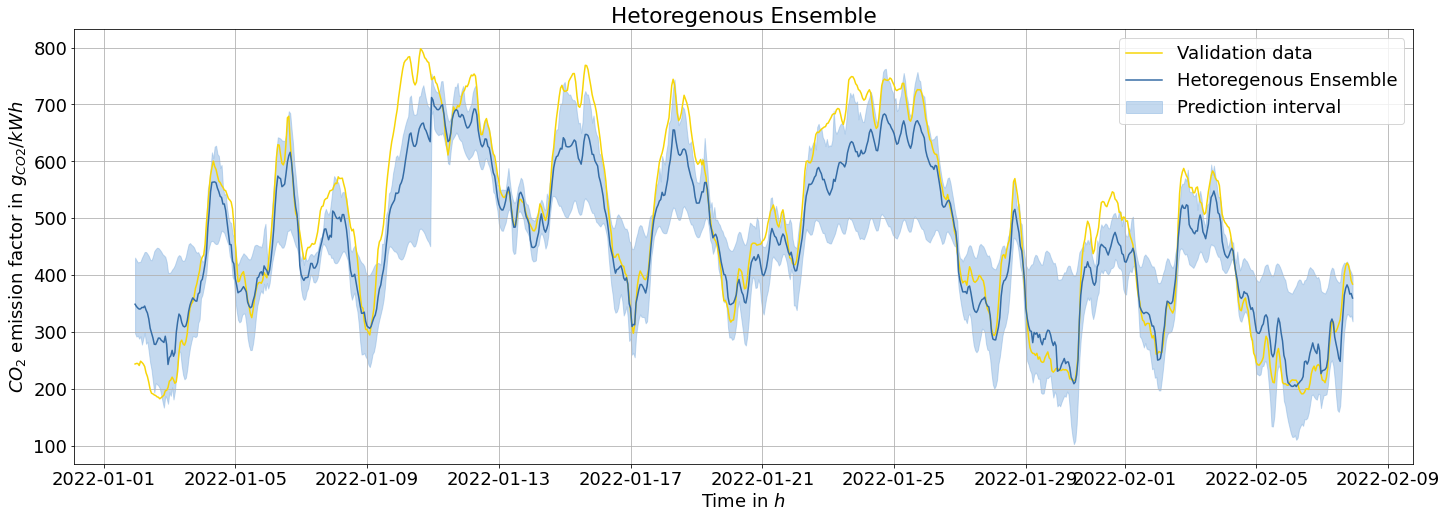

In [51]:
fun.plot_model_uncertainty2(co2_val, pred_val_df,lower_val_df ,upper_val_df, date_val, slice_start = '2022-01-01 23:00', slice_end =  '2022-02-15 23:00' , method = 'Hetoregenous Ensemble')

In [1]:
prediction_step = int(len(co2_test) / 125)
print(prediction_step)
alpha_low = 0.025
alpha_high = 0.975

NameError: ignored

# Walk forward testing

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (2,0,1)
seasonal_config = (2,0,2,forecast_period)
sarmax = SARIMAX(endog = co2_train_val, exog= features_train_val,  order = config_sarma, seasonal_order  = seasonal_config)
sarmax_fit= sarmax.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (3,0,1)
seasonal_config = (1,0,1,24)
sarma = SARIMAX(co2_train_val, order = config_sarma, seasonal_order = seasonal_config)
sarma_fit = sarma.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
len(co22) - len(co2_test)

27216

In [ ]:
len(co2_train_val)

27216

In [ ]:
sarmax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         emission_factor   No. Observations:                27216
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood             -100110.741
Date:                                 Tue, 27 Sep 2022   AIC                         200301.481
Time:                                         13:17:44   BIC                         200629.944
Sample:                                              0   HQIC                        200407.363
                                               - 27216                                         
Covariance Type:                                   opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
windon_forecast                   -0.0092      0.000    -83.037      0.000      -0.009      -0.009
windoff_forecast                  -0.0103      0.000    -33.248      0.000      -0.011      -0.010
solar_forecast                    -0.0102      0.000    -74.451      0.000      -0.010      -0.010
prices_forecast                    0.0110      0.010      1.112      0.266      -0.008       0.030
aggregated_generation_forecast     0.0034   6.31e-05     53.057      0.000       0.003       0.003
AT_import                      -6.892e-05      0.000     -0.222      0.824      -0.001       0.001
AT_export                       -3.98e-05      0.000     -0.276      0.782      -0.000       0.000
CZ_import                          0.0010      0.000      2.970      0.003       0.000       0.002
CZ_export                          0.0012      0.000      3.857      0.000       0.001       0.002
DK_import                          0.0020      0.000      8.114      0.000       0.002       0.002
DK_export                          0.0006      0.000      2.205      0.027    6.76e-05       0.001
LU_import                         -0.8287      0.009    -88.964      0.000      -0.847      -0.810
LU_export                          0.0431      0.004      9.956      0.000       0.035       0.052
NL_import                          0.0015      0.000      6.947      0.000       0.001       0.002
NL_export                         -0.0004      0.000     -2.922      0.003      -0.001      -0.000
PL_import                          0.0001      0.001      0.192      0.848      -0.001       0.001
PL_export                         -0.0009      0.001     -1.701      0.089      -0.002       0.000
CH_import                         -0.0004      0.000     -1.766      0.077      -0.001    4.82e-05
CH_export                          0.0006      0.000      1.376      0.169      -0.000       0.001
co2_24_lag                         0.0932      0.006     14.721      0.000       0.081       0.106
co2_26_lag                         0.0500      0.006      7.937      0.000       0.038       0.062
day_of_week_fri                  353.8454      5.108     69.274      0.000     343.834     363.857
day_of_week_mon                  372.1531      5.023     74.086      0.000     362.308     381.999
day_of_week_sat                  336.5558      5.071     66.370      0.000     326.617     346.495
day_of_week_sun                  344.0527      5.022     68.514      0.000     334.210     353.895
day_of_week_thu                  360.6967      5.147     70.082      0.000     350.609     370.784
day_of_week_tue                  365.5282      5.117     71.428      0.000     355.498     375.558
day_of_week_wed                  364.0565      5.134     70.905      0.000     353.993     374.120
hour_of_day_sin    

In [ ]:
pred_test, report_test, lower_test, upper_test, pred = het.walk_forward_validation_het(co22, features2, co2_test, co2_copy, features_copy, scaler_co2,  prediction_step, sarma_fit, sarmax_fit, machine_learning, alpha_low, alpha_high, n_features, activation, loss, optimizer_mlp, optimizer_lstm, 'Het Ensemble')
print(report_val)

1134
Epoch 1/100
1701/1701 [==============================] - 15s 7ms/step - loss: 10134.5107
Epoch 2/100
1701/1701 [==============================] - 11s 7ms/step - loss: 6042.7417
Epoch 3/100
1701/1701 [==============================] - 11s 7ms/step - loss: 4912.4360
Epoch 4/100
1701/1701 [==============================] - 11s 7ms/step - loss: 3956.4839
Epoch 5/100
1701/1701 [==============================] - 11s 7ms/step - loss: 3014.4033
Epoch 6/100
1701/1701 [==============================] - 11s 7ms/step - loss: 2697.5776
Epoch 7/100
1701/1701 [==============================] - 11s 7ms/step - loss: 2548.5405
Epoch 8/100
1701/1701 [==============================] - 11s 7ms/step - loss: 2467.9421
Epoch 9/100
1701/1701 [==============================] - 11s 7ms/step - loss: 2403.9087
Epoch 10/100
1701/1701 [==============================] - 11s 7ms/step - loss: 2365.8706
Epoch 11/100
1701/1701 [==============================] - 11s 7ms/step - loss: 2282.6741
Epoch 12/100
1701/1701 [

[array([529.7524 , 530.3429 , 538.408  , 529.8265 , 531.758  , 528.8896 ,
       523.9612 , 543.4393 , 522.23456, 497.81058, 463.70245, 453.00473,
       445.52615, 451.44147, 466.18515, 485.73068, 508.70117, 521.1618 ,
       525.3393 , 523.8651 , 507.52942, 497.42792, 494.99576, 478.59274],
      dtype=float32)]
Epoch 1/40
284/284 [==============================] - 5s 13ms/step - loss: 1.8113 - val_loss: 0.0382
Epoch 2/40
284/284 [==============================] - 3s 11ms/step - loss: 0.0717 - val_loss: 0.0536
Epoch 3/40
284/284 [==============================] - 3s 11ms/step - loss: 0.0622 - val_loss: 0.0220
Epoch 4/40
284/284 [==============================] - 3s 11ms/step - loss: 0.0647 - val_loss: 0.1190
Epoch 5/40
284/284 [==============================] - 3s 11ms/step - loss: 0.0613 - val_loss: 0.1096
Epoch 6/40
284/284 [==============================] - 3s 11ms/step - loss: 0.0688 - val_loss: 0.0089
Epoch 7/40
284/284 [==============================] - 3s 11ms/step - loss: 0.0

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 59/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1723.8201
Epoch 60/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1748.1586
Epoch 61/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1738.7070
Epoch 62/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1719.6306
Epoch 63/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1717.7877
Epoch 64/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1713.5125
Epoch 65/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1719.3967
Epoch 66/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1730.1876
Epoch 67/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1712.0303
Epoch 68/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1722.9565
Epoch 69/100
1754/1754 [===================

In [ ]:
print(report_test)

MAE for Het Ensemble: 32.26 g_CO2/kWh
MAPE for Het Ensemble: 6.76 %
RMSE for Het Ensemble: 40.24 g_CO2/kWh
Pinball for lower Quantile Het Ensemble: 2.18 g_CO2/kWh
Pinball for higher Quantile Het Ensemble: 6.21 g_CO2/kWh
Interval Score Het Ensemble: 107.7492 g_CO2/kWh
Real Values insisde PI Het Ensemble: 67.53 %
R2 Het Ensemble: 92.71000000000001 %
Adjusted R2 Het Ensemble: 92.63 %


In [ ]:
het_test_report_01 = open("/content/drive/MyDrive/Colab Notebooks/Master_thesis/master_thesis_collab/het_test_report_wf_01.txt", 'w')
het_test_report_01.write(report_test)
het_test_report_01.close()

In [ ]:
pred_test_df = pd.DataFrame(pred_test)
pred_test_df.to_csv('heto_mean_wf_test.csv')
pred_test_df.head() 

NameError: ignored

In [ ]:
upper_test_df = pd.DataFrame(upper_test)
upper_test_df.to_csv('heto_upper_wf_test.csv')
upper_test_df.head()

,0
0,383.266456
1,375.253703
2,372.093200
3,369.877320
4,371.031148


In [ ]:
lower_test_df = pd.DataFrame(lower_test)
lower_test_df.to_csv('heto_lower_wf_test.csv')
lower_test_df

,0
0,325.044083
1,306.661965
2,288.262043
3,279.669207
4,283.230404
...,...
2995,544.701411
2996,553.058995
2997,562.521563
2998,562.096307


In [26]:
heto_test_df = pd.read_csv('heto_mean_wf_test.csv')

In [27]:
heto_test_df = heto_test_df.drop(columns='Unnamed: 0')
heto_test_df.head()

,0
0,355.782780
1,342.105658
2,331.822281
3,328.364961
4,319.687282


In [28]:
lower_test_df = pd.read_csv('heto_lower_wf_test.csv')

In [29]:
lower_test_df = lower_test_df.drop(columns='Unnamed: 0')
lower_test_df.head()

,0
0,325.044083
1,306.661965
2,288.262043
3,279.669207
4,283.230404


In [30]:
upper_test_df = pd.read_csv('heto_upper_wf_test.csv')

In [31]:
upper_test_df = upper_test_df.drop(columns='Unnamed: 0')
upper_test_df.head()

,0
0,383.266456
1,375.253703
2,372.093200
3,369.877320
4,371.031148


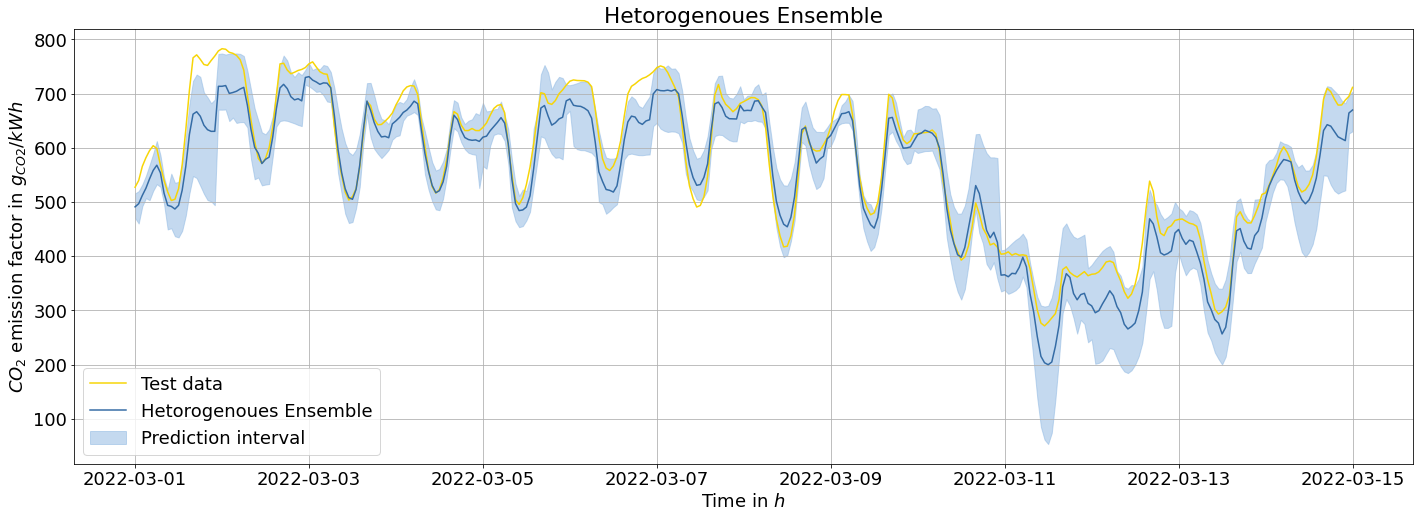

In [33]:
fun.plot_model_uncertainty(co2_test, heto_test_df,lower_test_df,upper_test_df, date_test, slice_start = '2022-03-01 00:00', slice_end =  '2022-03-15 00:00', method = 'Hetorogenoues Ensemble')

# Additional ensemble methods experementation

In [ ]:
 pred

[array([[568.23432107],
        [573.34977213],
        [587.31989425],
        ...,
        [406.52898501],
        [404.67541985],
        [383.45715523]])]

In [ ]:
preds

[array([509.39804354, 507.82222199, 505.54956121, ...,  50.20650325,
         48.38474589,  46.22370115]),
 array([509.26726713, 496.95528833, 490.1110691 , ..., 364.89486771,
        364.78589441, 351.60120583])]

In [ ]:
pred = np.array(pred, dtype = float)

ValueError: ignored

In [ ]:
np.quantile(pred, 0.025)

234.44231366519824

In [ ]:
preds = []

#pred_LR = LR.predict(features_val)
#pred_Bagging = Bagging.predict(features_val)
#pred_RF = RF.predict(features_val)
#pred_GD = GD.predict(features_val)
#pred_mlp = mlp.predict(features_val)
preds_sarmax = (sarmax_fit.get_forecast(len(features_val), exog = features_val))
pred_sarmax = np.array(preds_sarmax.predicted_mean)
preds_sarma = (sarma_fit.get_forecast(len(features_val)))
pred_sarma = np.array(preds_sarma.predicted_mean)

preds.append(pred_sarma)
preds.append(pred_sarmax)
#preds.append(pred_LR)
#preds.append(pred_Bagging)#
#preds.append(pred_RF)
#preds.append(pred_GD)
#preds.append(pred_mlp.reshape(6048,))

In [ ]:
np.array(pred_sarmax)

array([509.26726713, 496.95528833, 490.1110691 , ..., 364.89486771,
       364.78589441, 351.60120583])

In [ ]:
pred_sarmax.shape

(6048,)

In [ ]:
pred_mlp.reshape(6048,)

array([528.6347 , 526.4592 , 532.2328 , ..., 315.99673, 322.39334,
       305.89597], dtype=float32)

In [ ]:
preds_val_df = pd.DataFrame(preds).T
preds_val_df

,0,1,2,3,4,5,6
0,509.427575,509.267267,537.689459,514.396500,523.220798,488.421652,528.634705
1,507.913395,496.955288,533.025100,523.049433,523.894638,508.315378,526.459229
2,505.717622,490.111069,537.265448,532.154331,534.638862,516.392473,532.232788
3,510.748566,497.031491,547.086399,542.710177,545.289707,527.384879,543.855896
4,520.939769,509.092416,563.056284,563.547975,561.674682,563.871135,560.999390
...,...,...,...,...,...,...,...
6043,55.744774,380.476597,382.405236,373.175916,383.473636,428.437903,350.716492
6044,56.212439,374.106615,366.313071,398.031748,378.825790,414.150243,343.681458
6045,55.037201,364.894868,337.641826,394.729097,368.057874,387.630668,315.996735
6046,53.035053,364.785894,343.321684,405.236352,371.508859,415.522343,322.393341


In [ ]:
preds?

In [ ]:
mean = np.mean(preds, axis = 0)
mean

array([509.33265533, 502.38875516, 497.83031516, ..., 207.55068548,
       206.58532015, 198.91245349])

In [ ]:
lower= np.quantile(preds, 0.025, axis = 0)
lower

array([509.27053654, 497.22696167, 490.49703141, ...,  58.07371236,
        56.29477461,  53.85813877])

In [ ]:
upper= np.quantile(preds, 0.975, axis = 0)
upper

array([509.39477413, 507.55054865, 505.16359891, ..., 357.0276586 ,
       356.8758657 , 343.96676821])

In [ ]:
co2_val

21168    506.521267
21169    504.916659
21170    513.695182
21171    523.851760
21172    540.933495
            ...    
27211    421.243254
27212    417.438725
27213    406.833526
27214    390.330244
27215    384.171132
Name: emission_factor, Length: 6048, dtype: float64

In [ ]:
rep = fun.evaluation(mean,lower, upper, co2_val,0.025,0.975,n_features, 'heto')
print(rep)

MAE for heto: 63.24 g_CO2/kWh
MAPE for heto: 12.3 %
RMSE for heto: 74.42 g_CO2/kWh
Pinball for lower Quantile heto: 7.66 g_CO2/kWh
Pinball for higher Quantile heto: 7.05 g_CO2/kWh
Interval Score heto: 338.3629 g_CO2/kWh
Real Values insisde PI heto: 72.88 %
R2 heto: 68.74 %
Adjusted R2 heto: 68.57 %


## Stacking

In [ ]:
## split training data
co2_level_1 = co2_train[0:int(0.5*len(co2_train))]
co2_level_2 = co2_train[int(0.5*len(co2_train)) : len(co2_train)]

features_level_1 = features_train[0:int(0.5*len(co2_train))]
features_level_2 = features_train[int(0.5*len(co2_train)) : len(co2_train)]

co2_level_1.shape,co2_level_2.shape, features_level_1.shape, features_level_2.shape

((10584,), (10584,), (10584, 32), (10584, 32))

In [ ]:
# level predictions
LR = LinearRegression()
LR.fit(features_level_1, co2_level_1)
KNN = KNeighborsRegressor()
KNN.fit(features_level_1, co2_level_1)
svr = SVR()
svr.fit(features_level_1, co2_level_1)
Bagging = BaggingRegressor(base_estimator=None,bootstrap=True, max_samples=1.0,
                 n_estimators=1000, n_jobs=6, random_state = 42) 
Bagging.fit(features_level_1, co2_level_1)
RF = RandomForestRegressor(max_depth = 50,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 n_estimators = 1000,
 random_state = 42)
RF.fit(features_level_1, co2_level_1)
GD = GradientBoostingRegressor(learning_rate=0.3, loss = 'squared_error',
    n_estimators= 350,
    #mean_sample_split = 8
    max_depth = 3,
    subsample = 1.0, random_state = 42)
GD.fit(features_level_1, co2_level_1)



GradientBoostingRegressor(learning_rate=0.3, n_estimators=350, random_state=42)

In [ ]:
preds_val = []

#pred_LR = LR.predict(features_val)
pred_Bagging = Bagging.predict(features_level_2)
pred_RF = RF.predict(features_level_2)
pred_GD = GD.predict(features_level_2)
pred_KNN = KNN.predict(features_val)
pred_svr = svr.predict(features_level_2)
pred_LR = LR.predict(features_level_2)

#preds.append(pred_LR)
preds_val.append(pred_Bagging)
preds_val.append(pred_RF)
preds_val.append(pred_GD)
#preds_val.append(pred_KNN)
preds_val.append(pred_svr)
preds_val.append(pred_LR)

In [ ]:
preds_l2_df_train = pd.DataFrame(preds_val).T
preds_l2_df_train

,0,1,2,3,4,5
0,459.033646,495.607397,502.723971,547.199699,562.915470,580.452465
1,348.297048,441.129232,463.634552,536.003780,551.455505,550.630919
2,350.284716,428.904109,454.706464,544.517238,541.711997,526.518043
3,347.301407,419.077218,436.525314,553.136380,531.380891,504.145928
4,347.123249,397.934485,428.750478,566.998741,527.249096,499.094040
...,...,...,...,...,...,...
10579,605.407301,598.392955,608.546369,NaN,555.106938,617.221479
10580,614.197704,602.922834,599.964281,NaN,545.120883,603.213996
10581,600.604278,599.439734,579.172775,NaN,535.973699,579.932684
10582,592.116504,591.313663,567.173876,NaN,526.902226,556.529018


In [ ]:
preds_l2_df_train = preds_l2_df_train.drop(columns=3)

In [ ]:
Stacking = RandomForestRegressor(max_depth = 50,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 n_estimators = 1000,
 random_state = 42)
Stacking.fit(preds_l2_df_train, co2_level_2)

RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=1000,
                      random_state=42)

In [ ]:
preds_val_df = preds_val_df.drop(columns = 3)

KeyError: ignored

In [ ]:
preds_level_2 = Stacking.predict(preds_val_df)

In [ ]:
preds_level_2

array([502.03001485, 503.71477889, 524.85882815, ..., 355.79033798,
       353.96276765, 364.82387237])

In [ ]:
report = fun.evaluation_without_uncertainty(preds_level_2, co2_val, method  = 'Stacking')
print(report)

MAE for Stacking: 36.18 g_CO2/kWh
MAPE for Stacking: 8.110000000000001 %
RMSE for Stacking: 45.48 g_CO2/kWh
R2 Stacking: 88.32 %


In [ ]:
####SuperBooster

In [ ]:
co2_train

In [ ]:
super_train = pd.concat([preds_df_train, features_train], axis = 1)
super_train

,0,1,2,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,317.523677,313.917416,332.613232,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,1,0,0,0,0,0,-0.258819,9.659258e-01,-0.000717,1.000000
1,263.799595,265.023179,279.482829,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,0,0,0,0,1,0,0.000000,1.000000e+00,0.000000,1.000000
2,257.811976,258.230771,261.255534,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0,0,0,0,1,0,0.258819,9.659258e-01,0.000717,1.000000
3,254.696005,253.471019,255.363659,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0,0,0,0,1,0,0.500000,8.660254e-01,0.001435,0.999999
4,246.441562,247.705998,250.946757,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0,0,0,0,1,0,0.707107,7.071068e-01,0.002152,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,560.638528,554.605699,561.784414,3886.25,817.50,1228.0,86.00,49388.0,1014.0,0.0,...,1,0,0,0,0,0,-1.000000,-1.836970e-16,0.519744,-0.854322
21164,558.624466,554.767583,555.301980,5053.75,847.50,83.0,82.00,48009.0,780.0,0.0,...,1,0,0,0,0,0,-0.965926,2.588190e-01,0.519131,-0.854695
21165,537.841183,538.970707,510.042432,5887.75,873.50,0.0,79.90,47769.0,43.0,0.0,...,1,0,0,0,0,0,-0.866025,5.000000e-01,0.518518,-0.855067
21166,521.360287,529.703803,488.235104,5939.75,899.75,0.0,72.67,44923.0,0.0,214.0,...,1,0,0,0,0,0,-0.707107,7.071068e-01,0.517904,-0.855439


In [ ]:
preds_df_test_2 = preds_df_test.copy()
preds_df_test_2.index = features_val.index

super_test = pd.concat([preds_df_test_2, features_val], axis = 1)
super_test

,0,1,2,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
21168,514.396500,523.220798,488.421652,5261.75,924.75,0.00,58.94,39481.0,0.0,320.0,...,1,0,0,0,0,0,-0.258819,9.659258e-01,0.516677,-0.856181
21169,523.049433,523.894638,508.315378,4878.00,897.75,0.00,56.50,37869.0,0.0,425.0,...,0,0,0,0,1,0,0.000000,1.000000e+00,0.516062,-0.856551
21170,532.154331,534.638862,516.392473,4505.50,845.50,0.00,56.23,37034.0,0.0,387.0,...,0,0,0,0,1,0,0.258819,9.659258e-01,0.515448,-0.856921
21171,542.710177,545.289707,527.384879,4237.50,779.25,1.25,56.95,37742.0,0.0,336.0,...,0,0,0,0,1,0,0.500000,8.660254e-01,0.514833,-0.857290
21172,563.547975,561.674682,563.871135,4040.75,674.25,395.25,62.00,40187.0,0.0,402.0,...,0,0,0,0,1,0,0.707107,7.071068e-01,0.514218,-0.857659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27211,373.175916,383.473636,428.437903,28306.75,5310.25,0.00,160.10,76741.0,0.0,4073.0,...,1,0,0,0,0,0,-1.000000,-1.836970e-16,0.605056,0.796183
27212,398.031748,378.825790,414.150243,27214.00,5533.00,0.00,155.01,74589.0,0.0,4239.0,...,1,0,0,0,0,0,-0.965926,2.588190e-01,0.605627,0.795749
27213,394.729097,368.057874,387.630668,26325.00,5797.50,0.00,129.64,71778.0,0.0,3415.0,...,1,0,0,0,0,0,-0.866025,5.000000e-01,0.606198,0.795314
27214,405.236352,371.508859,415.522343,25388.00,6014.25,0.00,123.16,70214.0,0.0,4206.0,...,1,0,0,0,0,0,-0.707107,7.071068e-01,0.606768,0.794879


In [ ]:
#Stacking = BaggingRegressor(base_estimator=None, bootstrap=True, max_samples=1.0,
#                 n_estimators=1000, n_jobs=6, random_state = 42)
#Super_Stacking = GradientBoostingRegressor(learning_rate=0.3, loss = 'squared_error',
#    n_estimators= 350,
#    #mean_sample_split = 8
#    max_depth = 3,
#    subsample = 1.0, random_state = 42)
Super_Stacking = BaggingRegressor(base_estimator=None, bootstrap=True, max_samples=1.0,
              n_estimators=500, n_jobs=6, random_state = 42)
Super_Stacking.fit(super_train, co2_train)

NameError: ignored

In [ ]:
super_preds = Super_Stacking.predict(super_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
super_preds

array([520.12968428, 522.49400186, 534.99151821, ..., 374.96152436,
       375.49660784, 374.94197972])

In [ ]:
report = fun.evaluation_without_uncertainty(super_preds, co2_val, method  = 'Stacking')
print(report)

MAE for Stacking: 36.76 g_CO2/kWh
MAPE for Stacking: 8.99 %
RMSE for Stacking: 47.55 g_CO2/kWh
R2 Stacking: 87.24 %


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_co2 = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))
co2_lstm = scaler_co2.fit_transform(np.array(co2).reshape(len(co2),1))
features_lstm = scaler_features.fit_transform(features)

In [ ]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train_lstm = co2_lstm[0:int(n*train_ratio)+1]
co2_train_val_lstm = co2_lstm[0:int(n*val_ratio)]
co2_val_lstm = co2_lstm[int(n*train_ratio)+1:int(n*val_ratio)+1]
co2_test_lstm = co2_lstm[int(n*val_ratio)+1:n-23]

# split the features into train and test set
features_train_lstm = features_lstm[0:int(n*train_ratio)+1]
features_train_val_lstm = features_lstm[0:int(n*val_ratio)]
features_val_lstm = features_lstm[int(n*train_ratio)+1:int(n*val_ratio)+1]
features_test_lstm = features_lstm[int(n*val_ratio)+1:n-23]

# split the date data
date_val = date[int(n*train_ratio)+1:int(n*val_ratio)+1]
date_test = date[int(n*val_ratio)+1:n-23]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [ ]:
# data shape
co2_copy = tf.reshape(co2_lstm[:len(co2_lstm)-23], shape = (int(len(co2_lstm[:len(co2_lstm)-23])/24),24,1))
features_copy = tf.reshape(features_lstm[:len(co2_lstm)-23], shape = (int(len(co2_lstm[:len(co2_lstm)-23])/24),24,32))

# train shape##
co2_copy_train = tf.reshape(co2_train_lstm, shape = (int(len(co2_train_lstm)/24),24,1))
features_copy_train = tf.reshape(features_train_lstm, shape = (int(len(co2_train_lstm)/24),24,32))

# validation shape
co2_copy_val = tf.reshape(co2_val_lstm, shape = (int(len(co2_val_lstm)/24),24,1))
features_copy_val = tf.reshape(features_val_lstm, shape = (int(len(co2_val_lstm)/24),24,32))

# train val shape
#co2_copy_train_val = tf.reshape(co2_train_val, shape = (int(len(co2_train_val)/24),24,1))
#features_copy_train_val = tf.reshape(features_train_val, shape = (int(len(co2_train_val)/24),24,32))
                                                          
# test shape
co2_copy_test = tf.reshape(co2_test_lstm, shape = (int(len(co2_test_lstm)/24),24,1))
features_copy_test = tf.reshape(features_test_lstm, shape = (int(len(co2_test_lstm)/24),24,32))


In [ ]:
# train_val set
labels_train_val = tf.concat([co2_copy_train, co2_copy_val], axis = 0)
print(labels_train_val.shape)

inputs_train_val = tf.concat([features_copy_train, features_copy_val], axis = 0)
print(inputs_train_val.shape)

(1134, 24, 1)
(1134, 24, 32)


In [ ]:
print(labels_train_val)

tf.Tensor(
[[[0.2277245 ]
  [0.17870823]
  [0.17263754]
  ...
  [0.10903327]
  [0.11382485]
  [0.11247965]]

 [[0.12746743]
  [0.12883961]
  [0.13736267]
  ...
  [0.54802321]
  [0.55962338]
  [0.5581923 ]]

 [[0.55191894]
  [0.5578107 ]
  [0.56884492]
  ...
  [0.76016873]
  [0.76925799]
  [0.75746598]]

 ...

 [[0.16419347]
  [0.14636881]
  [0.14127849]
  ...
  [0.08930048]
  [0.0901442 ]
  [0.08675384]]

 [[0.08526964]
  [0.09249967]
  [0.09687606]
  ...
  [0.13828466]
  [0.14186949]
  [0.13859056]]

 [[0.11672713]
  [0.09971338]
  [0.09857844]
  ...
  [0.39554345]
  [0.37003945]
  [0.36052123]]], shape=(1134, 24, 1), dtype=float64)


In [ ]:
learning_rate = 0.3
loss = 'mse'
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#activation = 'relu'
dp_rate = 0.1
metrics=[tf.keras.metrics.RootMeanSquaredError()]
initializer_lstm = tf.keras.initializers.GlorotNormal()
#initializer_lstm = tf.keras.initializers.GlorotNormal(seed=42)
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
#initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

In [ ]:
lstm = het.LSTM_model(n_features, loss, optimizer, dp_rate, initializer_lstm)